In [113]:
# @title **[1/5] Run project imports** { run: "auto", display-mode: "form" }

import copy
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as nptp
import pathlib
import prettytable
import threading
import typing as tp
import warnings

from dataclasses import dataclass, field
from sys import setrecursionlimit

setrecursionlimit(10 ** 9)
threading.stack_size(67108864)
%config InlineBackend.figure_format = 'retina'

# **Ergodic Markov Chain**

In [98]:
# @title **[3/5] Initialize Markov Chain**


@dataclass()
class ErgodicChain:
    matrix: nptp.NDArray
    eps: float = field(default=1e-6)
    num_iter: int = field(default=1000)
    errors: tp.List[float] = field(init=False, compare=False)

    def __init__(self,
                 matrix: tp.Sequence[tp.Sequence[float]],
                 eps: float = 1e-6,
                 num_iter: int = 1000) -> None:
        self.matrix = self.validate_matrix(np.array(matrix))
        self.eps = eps
        self.num_iter = num_iter
        self.errors = []

    @staticmethod
    def validate_matrix(matrix: nptp.NDArray) -> nptp.NDArray:
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError(f'matrix {matrix} should be square')
        if np.any(matrix < 0):
            raise ValueError(f'matrix {matrix} contains negative values')
        if not np.allclose(np.sum(matrix, axis=1), 1):
            raise ValueError(f'matrix {matrix} rows should be normalized')
        return matrix

    @staticmethod
    def validate_distribution(base: nptp.NDArray, shape: tp.Tuple[int, int]) -> nptp.NDArray:
        validated = copy.deepcopy(base)
        if len(validated.shape) > 1:
            validated = validated.ravel()
        if validated.shape[0] != shape[0]:
            raise ValueError(f'base vector shape {validated.shape} should match matrix shape {shape[0]}')
        if not np.isclose(np.sum(validated), 1.0):
            raise ValueError(f'base vector {validated} {np.sum(validated)}should be normalized')
        return validated

    def check_criteria(self, distribution: nptp.NDArray, other: nptp.NDArray) -> bool:
        norm = float(np.linalg.norm(distribution - other))
        self.errors.append(norm)
        return norm < self.eps

    def solve_numeric(self, base: tp.Sequence[float | tp.Sequence[float]]) -> nptp.NDArray:
        self.errors = []
        old_base = self.validate_distribution(np.array(base), self.matrix.shape)
        new_base = old_base @ self.matrix
        for i in range(self.num_iter):
            if self.check_criteria(old_base, new_base):
                return new_base
            old_base, new_base = new_base, new_base @ self.matrix
        warnings.warn('Numerical method did not converge, try changing eps and num_iter')
        return new_base

    def solve_analytic(self) -> nptp.NDArray:
        matrix = self.matrix.T - np.eye(self.matrix.shape[0])
        matrix[-1, :] = 1
        b_term = np.zeros((self.matrix.shape[0], 1))
        b_term[-1] = 1
        return (np.linalg.inv(matrix) @ b_term).T.ravel()

    def __str__(self) -> str:
        labels = [f's{i}' for i in range(self.matrix.shape[1])]
        table = prettytable.PrettyTable(
            field_names=["state"] + labels,
        )
        table.add_rows(
            [[labels[i]] + \
             list(map(lambda x: "{:.2f}".format(x), self.matrix[i])) \
             for i in range(self.matrix.shape[0])],
        )
        return table.get_string()

# **Benchmark and Tests**

In [103]:
# @title **[4/5] Initialize MVP Tests** { display-mode: "form" }

def generate_bases(dim: int, n_bases: int) -> tp.Generator[tp.Sequence[float], None, None]:
    for _ in range(n_bases):
        matrix = np.random.rand(1, dim)
        yield (matrix / np.sum(matrix)).tolist()


@dataclass()
class ErgodicChainCase:
    name: str
    bases: tp.Sequence[tp.Sequence[float]]
    matrix: tp.Sequence[tp.Sequence[float]]
    ground_truth: tp.Sequence[tp.Sequence[float]]
    eps: float = 1e-6
    num_iter: int = 1000


TEST_CHAINS = [
    ErgodicChainCase(
        name="3x3",
        bases=list(generate_bases(3, 2)),
        matrix=[
            [1/2, 1/4, 1/4],
            [1/3, 1/3, 1/3],
            [1/2, 1/2, 0],
        ],
        ground_truth=[
            [4/9, 1/3, 2/9],
        ],
    ),
    ErgodicChainCase(
        name="8x8",
        bases=list(generate_bases(8, 2)),
        matrix=[
            [1/4, 1/4, 1/4, 1/4, 0, 0, 0, 0],
            [1/3, 0, 1/3, 1/3, 0, 0, 0, 0],
            [0, 1/4, 1/4, 1/4, 1/4, 0, 0, 0],
            [1/3, 1/3, 0, 0, 1/3, 0, 0, 0],
            [0, 0, 1/4, 1/4, 1/4, 1/4, 0, 0],
            [0, 0, 0, 0, 1/3, 0, 1/3, 1/3],
            [0, 0, 0, 0, 0, 1/4, 1/4, 1/2],
            [0, 0, 0, 0, 0, 1/2, 0, 1/2],
        ],
        ground_truth=[
            [0.1134893, 0.11199602, 0.1433549, 0.1433549, 0.16724739, 0.12543554, 0.05574913, 0.13937282],
        ],
    ),
]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~START-TEST[0][3x3]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
+-------+------+------+------+
| state |  s0  |  s1  |  s2  |
+-------+------+------+------+
|   s0  | 0.50 | 0.25 | 0.25 |
|   s1  | 0.33 | 0.33 | 0.33 |
|   s2  | 0.50 | 0.50 | 0.00 |
+-------+------+------+------+
Analytic solution: [0.44444444 0.33333333 0.22222222]

Numeric solution: [0.44444439 0.33333323 0.22222239]
base_0: [[0.49912446067748717, 0.03721929765633627, 0.46365624166617664]]
eps=1e-06, num_iter=1000

Numeric solution: [0.4444444  0.33333325 0.22222234]
base_1: [[0.2326337203788858, 0.3227006983919964, 0.4446655812291177]]
eps=1e-06, num_iter=1000



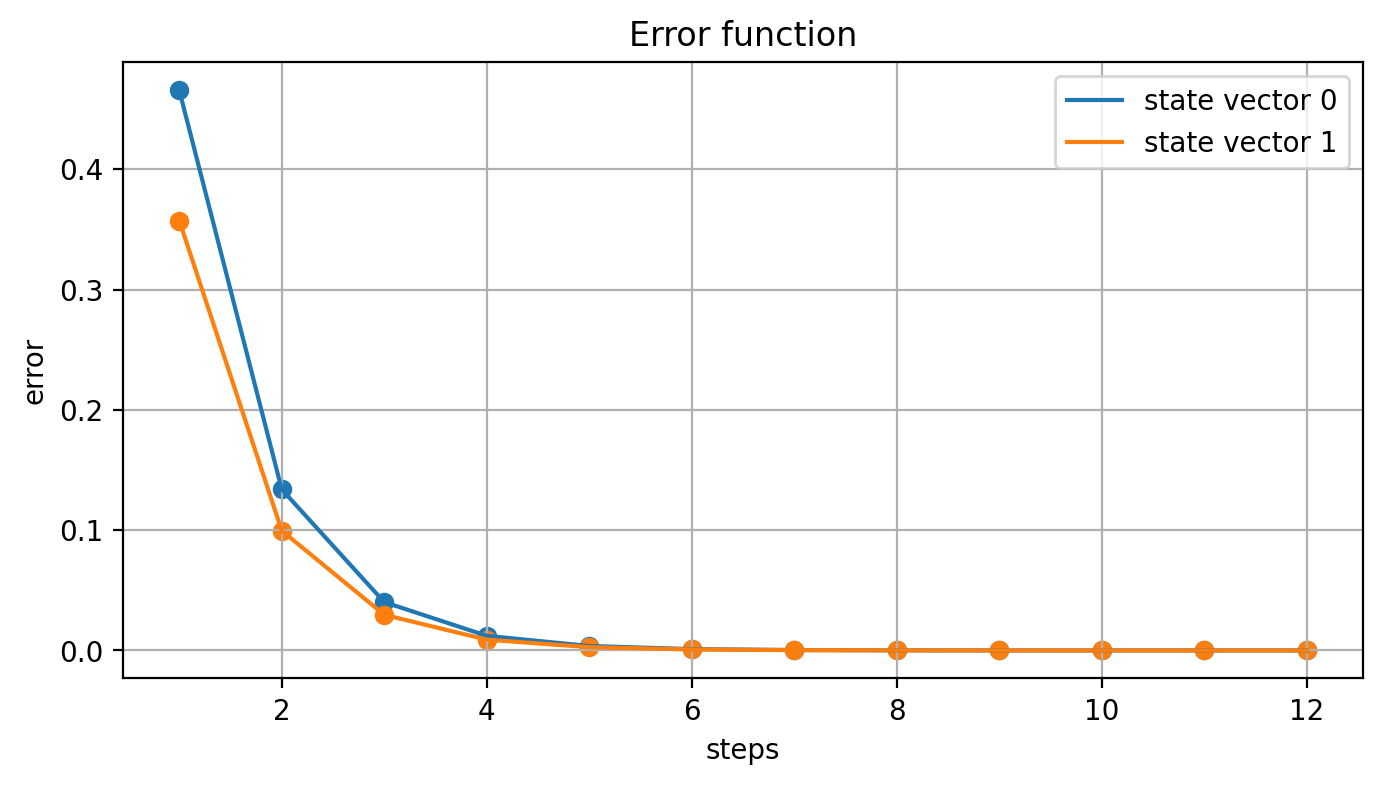

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~END-TEST[0][3x3]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~START-TEST[1][8x8]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
+-------+------+------+------+------+------+------+------+------+
| state |  s0  |  s1  |  s2  |  s3  |  s4  |  s5  |  s6  |  s7  |
+-------+------+------+------+------+------+------+------+------+
|   s0  | 0.25 | 0.25 | 0.25 | 0.25 | 0.00 | 0.00 | 0.00 | 0.00 |
|   s1  | 0.33 | 0.00 | 0.33 | 0.33 | 0.00 | 0.00 | 0.00 | 0.00 |
|   s2  | 0.00 | 0.25 | 0.25 | 0.25 | 0.25 | 0.00 | 0.00 | 0.00 |
|   s3  | 0.33 | 0.33 | 0.00 | 0.00 | 0.33 | 0.00 | 0.00 | 0.00 |
|   s4  | 0.00 | 0.00 | 0.25 | 0.25 | 0.25 | 0.25 | 0.00 | 0.00 |
|   s5  | 0.00 | 0.00 | 0.00 | 0.00 | 0.33 | 0.00 | 0.33 | 0.33 |
|   s6  | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.25 | 0.25 | 0.50 |
|   s7  | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.50 | 0.00 | 0.50 |
+-------+------+------+------+------+------+------+------+------+
Analytic solution: [0.1134893  0.11199602 0

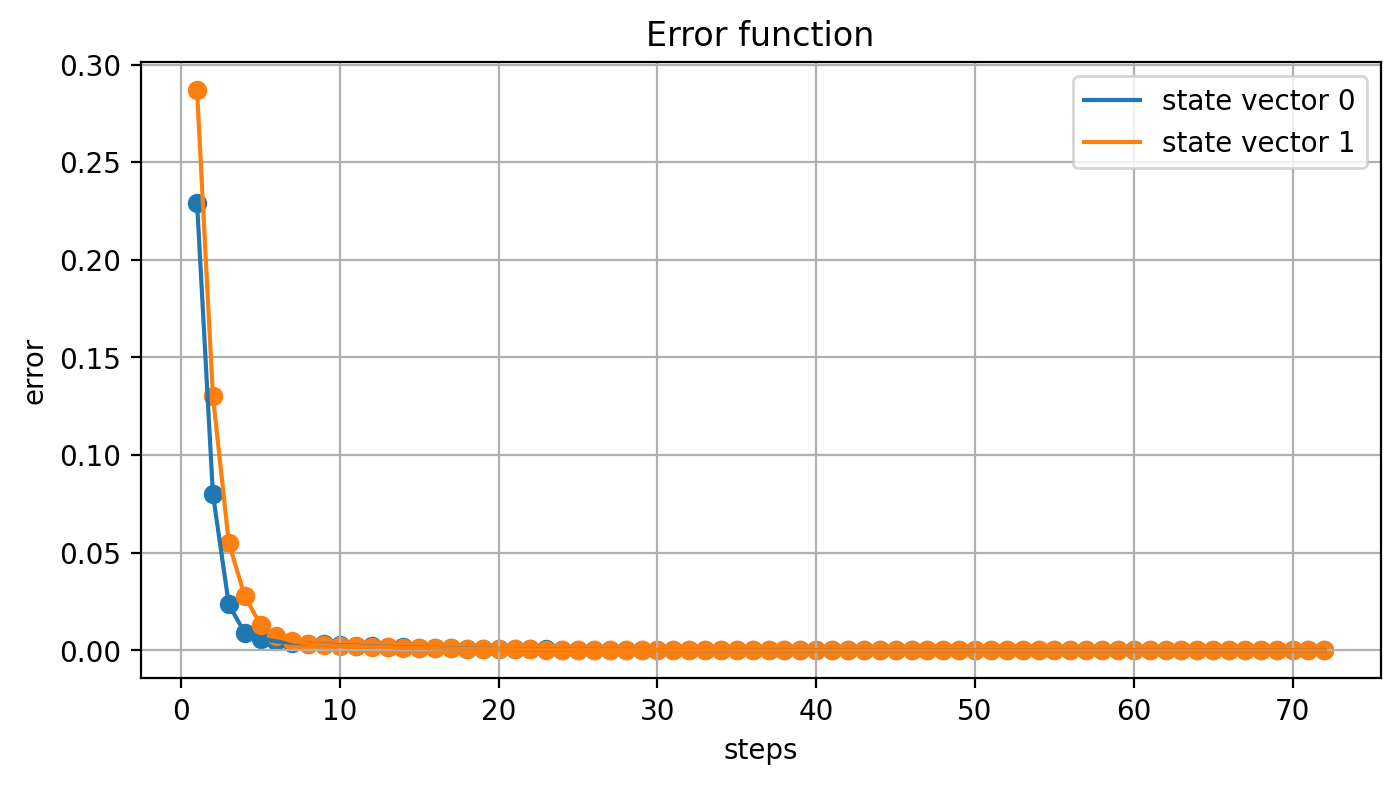

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~END-TEST[1][8x8]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





In [117]:
# @title **[5/5] Run MVP Tests!** { display-mode: "form" }

def plot_errors(errors: tp.Sequence[tp.Sequence[float]]) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i in range(len(errors)):
        steps = list(range(1, len(errors[i]) + 1))
        ax.scatter(steps, errors[i])
        ax.plot(steps, errors[i], label=f'state vector {i}')
    ax.set(title='Error function', xlabel='steps', ylabel='error')
    ax.legend()
    with plt.ion():
        plt.grid()
        plt.show()

for test_id, test in enumerate(TEST_CHAINS):
    try:
        errors = []
        print(f'START-TEST[{test_id}][{test.name}]'.center(80, '~'))
        chain = ErgodicChain(test.matrix, test.eps, test.num_iter)
        print(chain)
        distribution_analytic = chain.solve_analytic()
        print(f'Analytic solution: {distribution_analytic}\n')
        for i, base in enumerate(test.bases):
            distribution_numeric = chain.solve_numeric(base)
            errors.append(chain.errors)
            print(f'Numeric solution: {distribution_numeric}')
            print(f'base_{i}: {base}\neps={test.eps}, num_iter={test.num_iter}\n')
    except Exception as e:
        warnings.warn(f'Catched exception on {test_id}-{test.name} test: {e}')
    else:
        plot_errors(errors)
        assert np.allclose(distribution_analytic, np.array(test.ground_truth)), \
            f'Oops, matrices do not match'
        print(f'END-TEST[{test_id}][{test.name}]'.center(80, '~'), end='\n\n\n\n')